# EN3160 Assignment 02 : Fitting and Alignment

## Question 01

In [1]:
#Importing libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

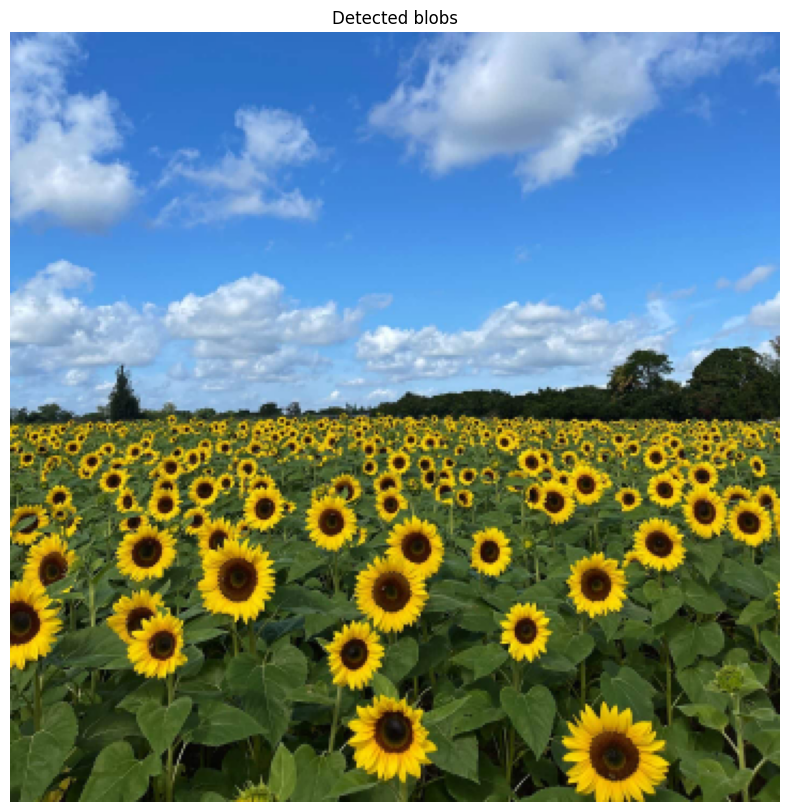

In [4]:
#Load images
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected blobs')
plt.show()

In [5]:
sigma_values = np.linspace(1, 2, 4)
threshold = 0.35
blob_responses = []

for sigma in sigma_values:
    print(f"Processing scale with sigma = {sigma}")
    gaussian_blur = cv.GaussianBlur(gray, (0, 0), sigma)
    laplacian = cv.Laplacian(gaussian_blur, cv.CV_64F)

    blob_response = np.abs(laplacian)

    mask = blob_response > threshold * blob_response.max()
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if len(contour) >= 5:
            (center_x, center_y), radius = cv.minEnclosingCircle(contour)
            center = (int(center_x), int(center_y))
            radius = int(radius)
            blob_responses.append((center, radius, sigma))

Processing scale with sigma = 1.0
Processing scale with sigma = 1.3333333333333333
Processing scale with sigma = 1.6666666666666665
Processing scale with sigma = 2.0


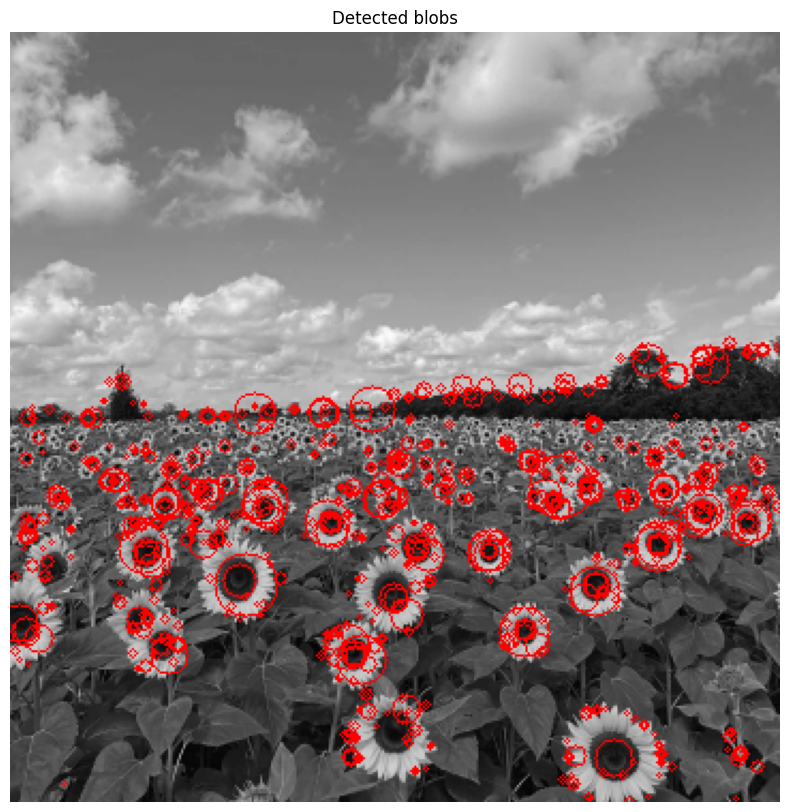

In [6]:
output = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)
for blob in blob_responses:
    center, radius, _ = blob
    cv.circle(output, center, radius, (0, 0, 255), 1)

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected blobs')
plt.show()

In [7]:
blobs_sorted = sorted(blob_responses, key=lambda x: x[1], reverse=True)
largest_blob = blobs_sorted[0]
center, radius, sigma = largest_blob

print(f"Largest blob at : {center} with radius {radius} and sigma {sigma}")

Largest blob at : (110, 258) with radius 15 and sigma 2.0


In [8]:
blobs_sorted = sorted(blob_responses, key=lambda x: x[1], reverse=True)
largest_blob = blobs_sorted[0]
center, radius, sigma = largest_blob

print(f"Largest blob at : {center} with radius {radius} and sigma {sigma}")

Largest blob at : (110, 258) with radius 15 and sigma 2.0


0.71,1.41,2.12,2.83,3.54,4.24,4.95,5.66,6.36,7.07,

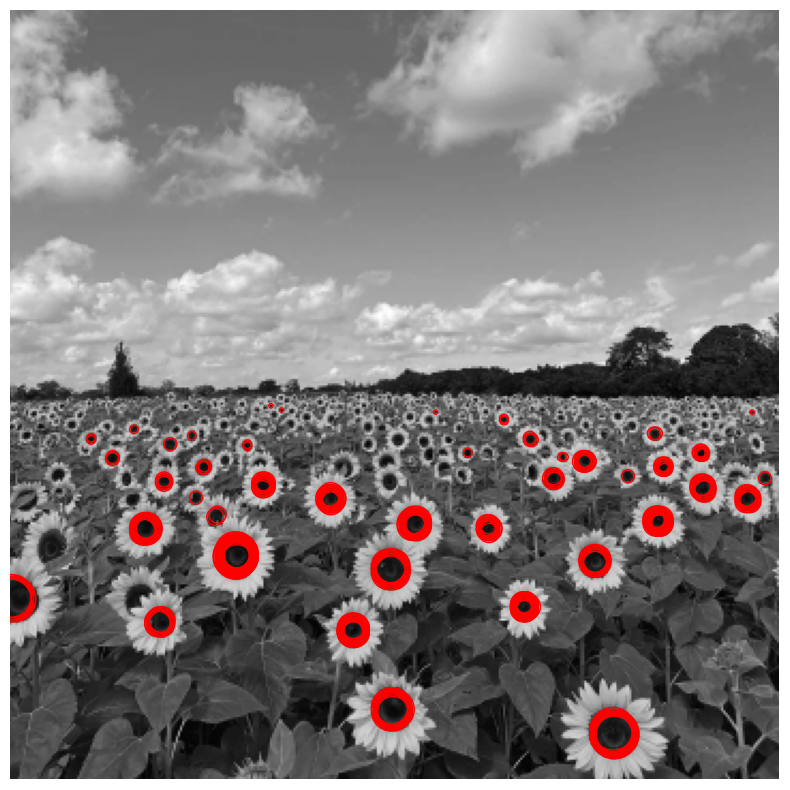

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the image and convert it to grayscale
img1 = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY) / 255

# Display the grayscale image with detected circles
plt.figure(figsize=(10, 10), frameon=False)
plt.imshow(gray, cmap='gray')
plt.axis('off')

# Get the current axes object
ax = plt.gca()

patches = []
labels = []

# Detect blobs at different sigma values
for r in range(1, 11):
    sigma = r / 1.414
    print(f"{sigma:.2f}", end=",")
    hw = round(3 * sigma)  # Half width of the kernel
    X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))

    # Calculate Laplacian of Gaussian (LoG) filter
    LOG = ((X**2 + Y**2) / (2 * sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Scale the filter and apply it to the image
    LOG = sigma**2 * LOG
    img1_log = np.square(cv.filter2D(gray, -1, LOG))

    # Detect maxima manually
    coordinates = []
    (H, W) = img1_log.shape
    k = 1  # Neighborhood size
    threshold = 0.1  # Threshold for maxima detection
    for i in range(k, H - k):
        for j in range(k, W - k):
            slice_img = img1_log[i - k:i + k + 1, j - k:j + k + 1]
            if np.max(slice_img) >= threshold:
                # Get coordinates of the maximum point
                x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                coordinates.append((i + x - k, j + y - k))
    coordinates = set(coordinates)

    # Plot circles around detected blobs
    for x, y in coordinates:
        c = plt.Circle((y, x), sigma * 1.414, color='r', linewidth=1, fill=False)
        ax.add_patch(c)
    patches.append(c)
    ax.plot()

ax.set_xlim([0, img1.shape[1]])
ax.set_ylim([img1.shape[0], 0])

# Add legend and title
plt.axis('off')
plt.show()


## Question 02


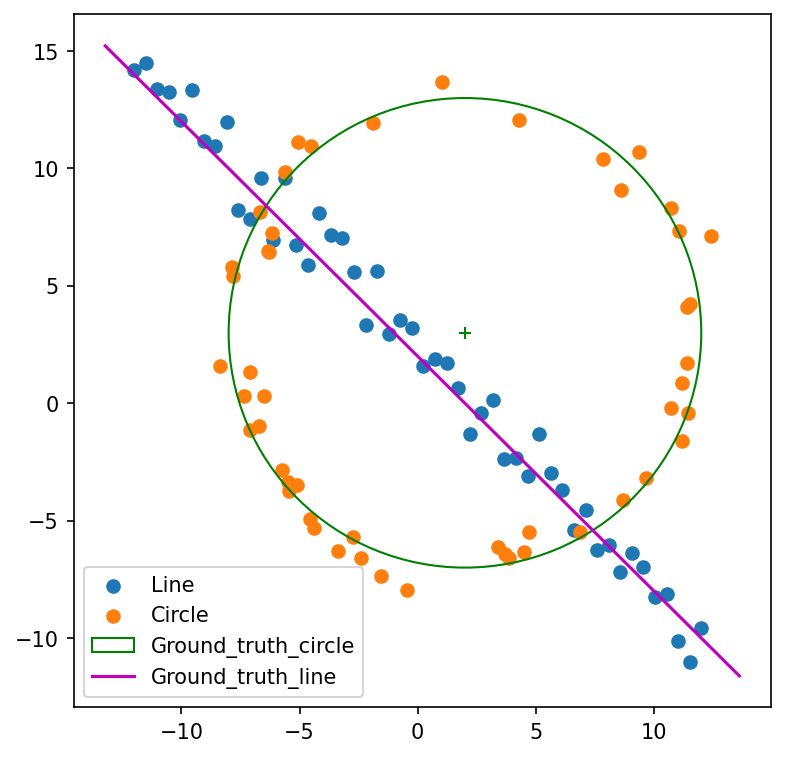

In [20]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
N = 100
half_n = N//2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r/16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = x0_gt + (r + n)*np.cos(t), y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=150)
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')
plt.legend()

### part (a): using the RNASAC algorithm

Estimated line: a=-0.72, b=-0.70, d=1.48
Estimated circle: x0=2.07, y0=3.03, r=10.11


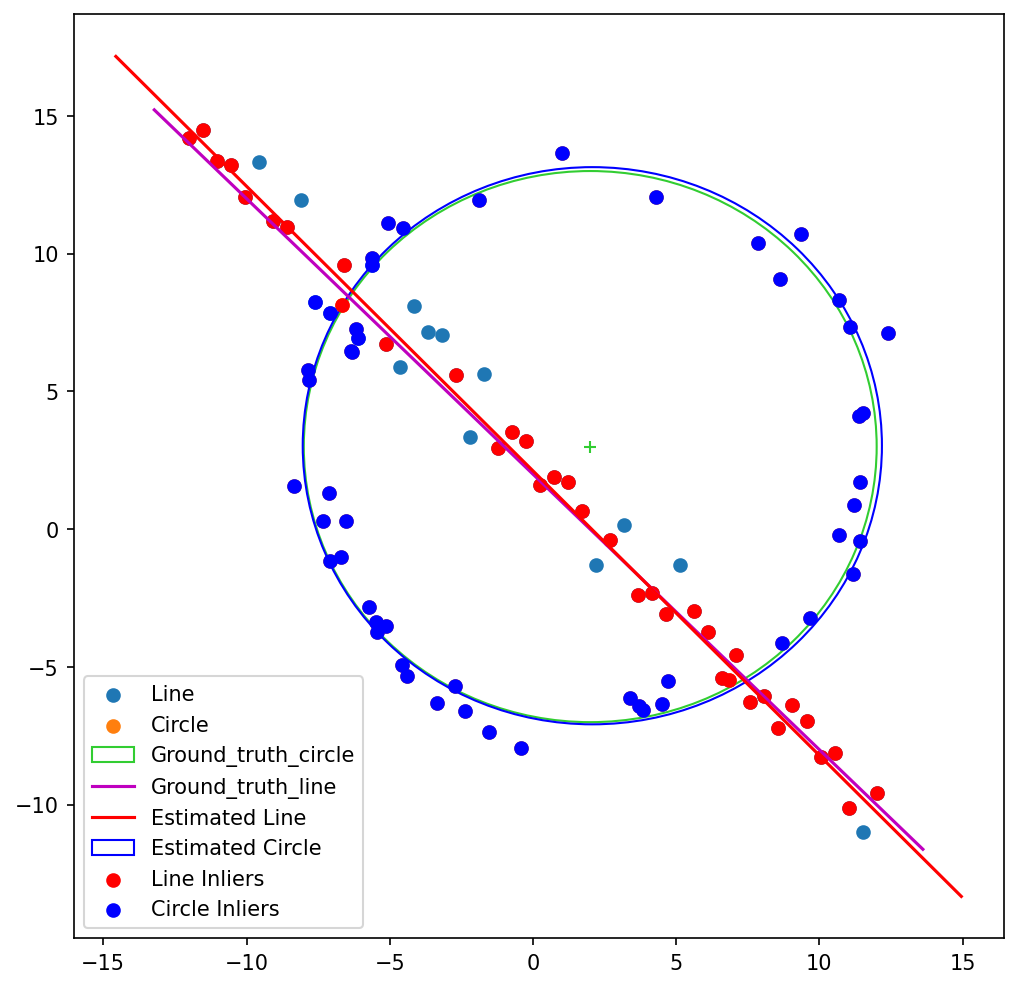

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Helper function to compute the distance from a point to a line ax + by + d = 0
def line_distance(params, X):
    a, b, d = params
    a_b_norm = np.sqrt(a**2 + b**2)
    distances = np.abs(a * X[:, 0] + b * X[:, 1] + d) / a_b_norm
    return distances

# RANSAC for line fitting
def ransac_line(X, num_iterations=1000, threshold=0.6, min_inliers=35):
    best_inliers = []
    best_params = None
    N = len(X)
    
    for _ in range(num_iterations):
        # Randomly sample 2 points
        sample_idx = np.random.choice(N, 2, replace=False)
        p1, p2 = X[sample_idx]
        
        # Compute line parameters from the two points
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = -(a * p1[0] + b * p1[1])
        
        # Ensure the constraint ||[a,b]|| = 1
        norm = np.sqrt(a**2 + b**2)
        a /= norm
        b /= norm
        d /= norm
        
        # Compute distances to the line
        distances = line_distance([a, b, d], X)
        
        # Find inliers
        inliers = X[distances < threshold]
        
        # Check if this model is the best
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_params = [a, b, d]
    
    return best_params, best_inliers

# Helper function to compute the radial distance from a point to a circle
def circle_distance(params, X):
    x0, y0, r = params
    distances = np.abs(np.sqrt((X[:, 0] - x0)**2 + (X[:, 1] - y0)**2) - r)
    return distances

# RANSAC for circle fitting
def ransac_circle(X, num_iterations=1000, threshold=1.5, min_inliers=45):
    best_inliers = []
    best_params = None
    N = len(X)
    for _ in range(num_iterations):
        # Randomly sample 3 points
        sample_idx = np.random.choice(N, 3, replace=False)
        p1, p2, p3 = X[sample_idx]
        
        # Compute circle parameters from the three points
        A = np.array([
            [p1[0], p1[1], 1],
            [p2[0], p2[1], 1],
            [p3[0], p3[1], 1]
        ])
        B = np.array([
            [-(p1[0]**2 + p1[1]**2)],
            [-(p2[0]**2 + p2[1]**2)],
            [-(p3[0]**2 + p3[1]**2)]
        ])
        # Solve for circle parameters
        try:
            C = np.linalg.solve(A, B)
            x0 = -0.5 * C[0][0]
            y0 = -0.5 * C[1][0]
            r = np.sqrt((x0**2 + y0**2) - C[2][0])
        except np.linalg.LinAlgError:
            continue
        # Compute radial distances
        distances = circle_distance([x0, y0, r], X)
        # Find inliers
        inliers = X[distances < threshold]
        # Check if this model is the best
        if len(inliers) > len(best_inliers) and len(inliers) >= min_inliers:
            best_inliers = inliers
            best_params = [x0, y0, r]
    
    return best_params, best_inliers

# Generate the dataset
np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

# Apply RANSAC to fit the line
best_line_params, line_inliers = ransac_line(X)

# Remove line inliers and apply RANSAC to fit the circle
remaining_points = np.array([pt for pt in X if pt not in line_inliers])
best_circle_params, circle_inliers = ransac_circle(remaining_points)

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=150)

# Plot the original points
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='limegreen', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='limegreen')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')

# Plot the estimated line
a, b, d = best_line_params
print(f"Estimated line: a={a:.2f}, b={b:.2f}, d={d:.2f}")
x_vals = np.array(ax.get_xlim())
y_vals = -(a * x_vals + d) / b
ax.plot(x_vals, y_vals, 'r-', label='Estimated Line')

# Plot the estimated circle
x0, y0, r = best_circle_params
print(f"Estimated circle: x0={x0:.2f}, y0={y0:.2f}, r={r:.2f}")
circle_est = plt.Circle((x0, y0), r, color='b', fill=False, label='Estimated Circle')
ax.add_patch(circle_est)

# Highlight line and circle inliers
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], color='red', label='Line Inliers', marker='o')
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], color='blue', label='Circle Inliers', marker='o')


# Show plot with ground truth
ax.legend()
plt.show()


In [24]:
print("Number of inliers in the line:", len(line_inliers))
print("Parameters of the estimated line:")
print(f"a: {best_line_params[0]}")
print(f"b: {best_line_params[1]}")
print(f"d: {best_line_params[2]}")

Number of inliers in the line: 36
Parameters of the estimated line:
a: -0.7184192033652615
b: -0.6956104141227495
d: 1.4753449080312475


In [25]:
print("Number of inliers in the circle:", len(circle_inliers))
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle_params[0]}")
print(f"y_center: {best_circle_params[1]}")
print(f"radius: {best_circle_params[2]}")

Number of inliers in the circle: 52
Parameters of the estimated circle:
x_center: 2.073201663265263
y_center: 3.031148268720096
radius: 10.11033486610821


## Question 03

## Question 04